Original code from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py under the following license:

MIT License

Copyright (c) 2017 Erik Linder-Norén

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The author's model was based on the paper here: https://arxiv.org/pdf/1511.06434.pdf

# Instructions

1. Go to https://colab.research.google.com and choose the \"Upload\" option to upload this notebook file.
1. In the Edit menu, choose \"Notebook Settings\" and then set the \"Hardware Accelerator\" dropdown to GPU.
1. Read through the code in the following sections:
  * [Define functions for model creation and training](#scrollTo=v7awMKS210hl)
  * [Create model objects](#scrollTo=suz991e610h-)
  * [Train model](#scrollTo=_ig7giYA10i0)
1. Complete at least one of these exercises
  * [Exercise Option #1 - Standard Difficulty](#scrollTo=NfUM0c3_10j4)
  * [Exercise Option #2 - Advanced Difficulty](#scrollTo=8DjAvBKR10j6)
  * [Exercise Option #3 - Advanced Difficulty](#scrollTo=uoO-aBOrsHWh)

In [1]:
# upgrade tensorflow to tensorflow 2
%tensorflow_version 2.x
# display matplotlib plots
%matplotlib inline

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow import test
from tensorflow import device

import matplotlib.pyplot as plt
from IPython.display import Image

import sys

import numpy as np

In [3]:
# Global Constants
images_dir = "dcgan_images"
img_rows = 28 
img_cols = 28
channels = 1
noise_len = 100

# Define functions for model creation and training

In [7]:
def build_discriminator():
    '''
    Put together a CNN that will return a single confidence output.
    
    returns: the model object
    '''

    img_shape = (img_rows, img_cols, channels)

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def build_generator():
    '''
    Put together a model that takes in one-dimensional noise and outputs two-dimensional
    data representing a black and white image, with -1 for black and 1 for white.
    
    returns: the model object
    '''

    noise_shape = (noise_len,)

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D(interpolation="bilinear"))
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D(interpolation="bilinear"))
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

def build_combined():
    '''
    Puts together a model that combines the discriminator and generator models.
    
    returns: the generator, discriminator, and combined model objects
    '''
    
    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])


    # Build and compile the generator
    generator = build_generator()

    # The generator takes noise as input and generates images
    noise = Input(shape=(noise_len,))
    img = generator(noise)
    
    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    valid = discriminator(img)

    # The combined model  (stacked generator and discriminator) takes
    # noise as input => generates images => determines validity 
    combined = Model(inputs=noise, outputs=valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator, discriminator, combined

def save_imgs(generator, iteration):
    '''
    Has the generator create images and saves the images in a single file that includes
    the number of iterations in the filename.
    
    inputs:
        generator: the generator model object returned by build_combined
        iteration: the iteration number (but can be anything that can be represented as a string)
    
    returns: None
    '''
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_len))
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray', vmin=-1, vmax=1)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_{}.png'.format(iteration)))
    plt.close()

def train(generator, discriminator, combined, iterations, batch_size=128, save_interval=50):
    '''
    Trains all model objects
    
    generator: the generator model object returned by build_combined
    discriminator: the discriminator model object returned by build_combined
    combined: the combined model object returned by build_combined
    iterations: integer, the number of iterations to train for
    batch_size: integer, the number of training samples to use at a time
    save_interval: integer, will generate and save images when the current iteration_num % save_interval is 0
    
    returns: None
    '''

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for iteration in range(iterations):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, noise_len))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real images classified as ones and generated images as zeros)
        real = 1
        fake = 0
        # Use noisy labels: about 10% of the time, swap the labels
        # (see https://github.com/soumith/ganhacks)
        if np.random.randint(0, 10) < 1:
            real = 0
            fake = 1
        d_loss_real = discriminator.train_on_batch(imgs, np.zeros((half_batch, 1)) + real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)) + fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, noise_len))

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # If at save interval => save generated image samples and plot progress
        if iteration % save_interval == 0:
            # Plot the progress
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print ("{} [D loss: {}, acc.: {:.2%}] [G loss: {}]".format(iteration, d_loss[0], d_loss[1], g_loss))
            save_imgs(generator, iteration)
            
def show_new_image(generator):
    '''
    Generates and displays a new image
    
    inputs: generator object model returned from build_combined
    
    returns: generated image
    '''
    
    noise = np.random.normal(0, 1, (1, noise_len))
    gen_img = generator.predict(noise)[0][:,:,0]
    
    return plt.imshow(gen_img, cmap='gray', vmin=-1, vmax=1)

# Create model objects

In [4]:
# set up directories to hold the images that are saved during training checkpoints.
import os

if (not os.path.isdir(images_dir)):
    os.mkdir(images_dir)

In [8]:
generator, discriminator, combined = build_combined()

We can take a look at what each of the models look like.

In [7]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)      

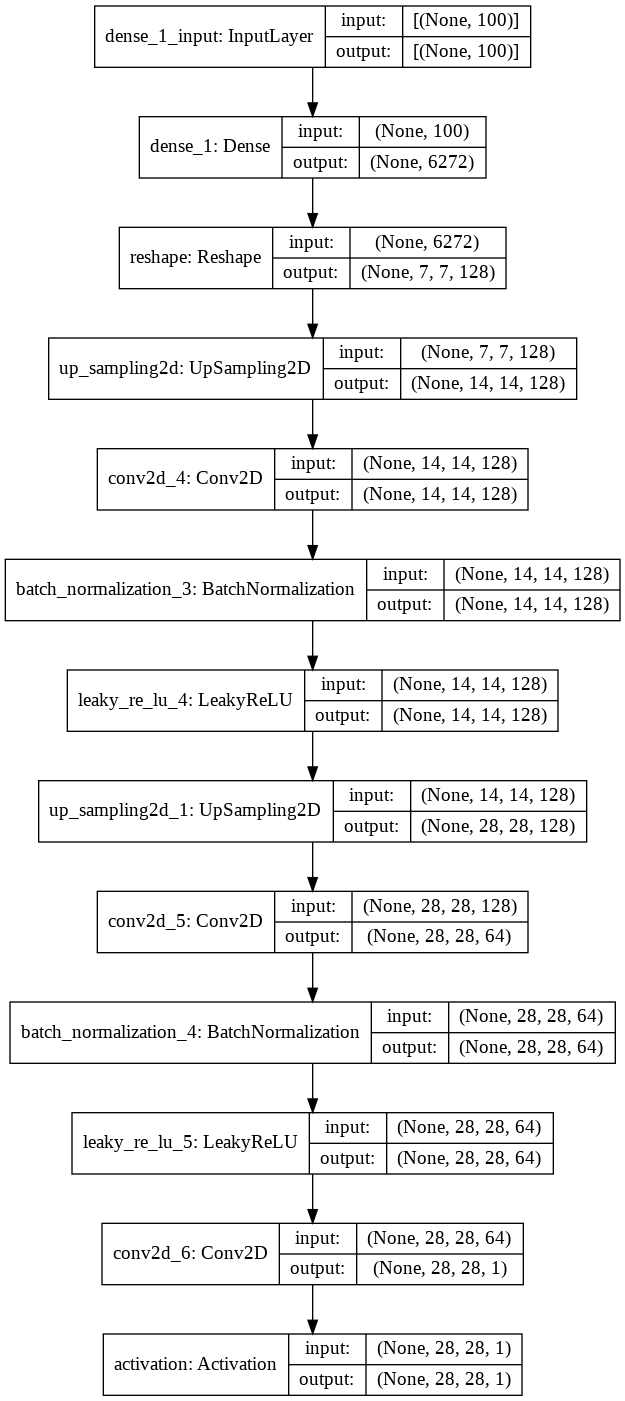

In [126]:
from keras.utils import plot_model
plot_model(generator, show_shapes=True)

In [8]:
# Note that we get a warning here about weights being trainable.
# When we are training the discriminator, we want its weights to be trainable.
# When we are training the generator, we want the discriminator weights to be fixed.
# This is surprising to Keras, so it is warning us to check that this is really what we want (it is!)
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

In [9]:
combined.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         856193    
_________________________________________________________________
sequential (Sequential)      (None, 1)                 393729    
Total params: 1,249,922
Trainable params: 855,809
Non-trainable params: 394,113
_________________________________________________________________


# Train model

In [10]:
# Train using GPU acceleration
# (see https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ)
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

# Lower the number of iterations when you start debugging! You want a short testing cycle until you are confident
# that the code is working. Also, since the exercises involve models with less complicated patterns, you will
# likely not need as many iterations to train well.
with device('/device:GPU:0'):
    train(generator, discriminator, combined, iterations=2001, batch_size=32, save_interval=50)

11493376/11490434 [==============================] - 0s 0us/step
0 [D loss: 1.2554903030395508, acc.: 40.62%] [G loss: 0.6335193514823914]
50 [D loss: 1.2184761762619019, acc.: 21.88%] [G loss: 0.7251856327056885]
100 [D loss: 0.6823173463344574, acc.: 56.25%] [G loss: 0.994589626789093]
150 [D loss: 0.7555875778198242, acc.: 53.12%] [G loss: 0.951683521270752]
200 [D loss: 0.751091480255127, acc.: 56.25%] [G loss: 1.0417859554290771]
250 [D loss: 1.3376025557518005, acc.: 25.00%] [G loss: 1.473667025566101]
300 [D loss: 0.7930475473403931, acc.: 62.50%] [G loss: 0.835555374622345]
350 [D loss: 0.6464748978614807, acc.: 62.50%] [G loss: 0.9416306018829346]
400 [D loss: 0.7835229635238647, acc.: 53.12%] [G loss: 0.8906058669090271]
450 [D loss: 0.3761618584394455, acc.: 84.38%] [G loss: 1.041672706604004]
500 [D loss: 0.392339825630188, acc.: 84.38%] [G loss: 0.5828226208686829]
550 [D loss: 2.1737599968910217, acc.: 0.00%] [G loss: 0.7662792205810547]
600 [D loss: 3.917300224304199, ac

You can look at the saved files to see what the model output looks like after a certain number of iterations:

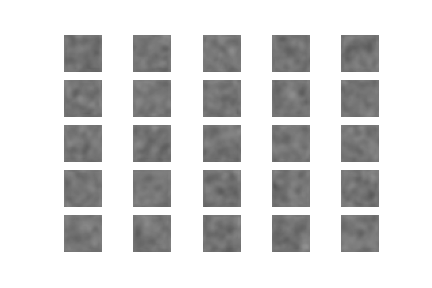

In [11]:
Image(filename=os.path.join(images_dir, 'mnist_0.png'))

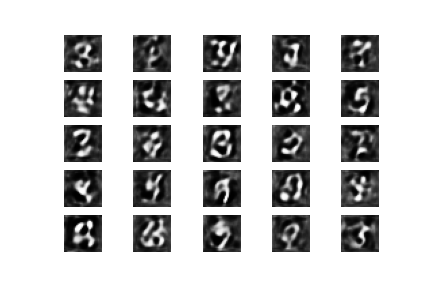

In [12]:
Image(filename=os.path.join(images_dir, 'mnist_500.png'))

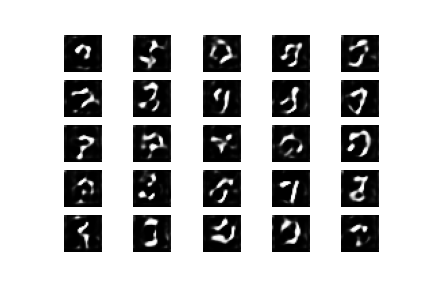

In [13]:
Image(filename=os.path.join(images_dir, 'mnist_2000.png'))

Let's have the trained model generate some images for us.

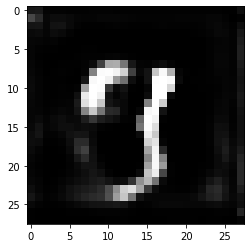

In [14]:
show_new_image(generator)

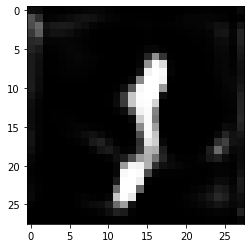

In [15]:
show_new_image(generator)

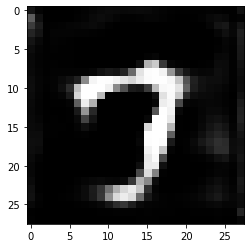

In [16]:
show_new_image(generator)

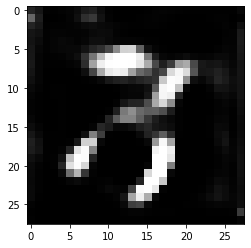

In [17]:
show_new_image(generator)

# Exercise Option #1 - Standard Difficulty
Change the model so that it learns to produce 9x9 images of some simple pattern, for instance horizontal lines.

# Exercise Option #2 - Advanced Difficulty
Change the model so that you can select which number you get an image of rather than always getting a random one. I highly recommend that you limit your model to only learning two or three numbers, so that you can get decent results with less training time.

Discriminator has to output 0, 2, or fake

This was my preliminary attempt where I made two separate models which produced different numbers. First I train on the number 8, and then on the number 5.

# Training the model on 8

In [53]:
def trainon8(generator, discriminator, combined, iterations, batch_size=128, save_interval=50):
    '''
    Trains all model objects
    
    generator: the generator model object returned by build_combined
    discriminator: the discriminator model object returned by build_combined
    combined: the combined model object returned by build_combined
    iterations: integer, the number of iterations to train for
    batch_size: integer, the number of training samples to use at a time
    save_interval: integer, will generate and save images when the current iteration_num % save_interval is 0
    
    returns: None
    '''

    # Load the dataset
    # ------ This is the part that I changed in order to filter for just the 8s in the dataset
    (X_train, y_train), (_, _) = mnist.load_data()
    fake_mask = np.array([y_train == 8])
    new_data = []
    for idx in range(0, len(X_train), 1):
        if fake_mask[0][idx]:
            new_data.append(X_train[idx].tolist())
    X_train = np.array(new_data)
    # ------

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for iteration in range(iterations):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, noise_len))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real images classified as ones and generated images as zeros)
        real = 1
        fake = 0
        # Use noisy labels: about 10% of the time, swap the labels
        # (see https://github.com/soumith/ganhacks)
        if np.random.randint(0, 10) < 1:
            real = 0
            fake = 1
        d_loss_real = discriminator.train_on_batch(imgs, np.zeros((half_batch, 1)) + real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)) + fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, noise_len))

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # If at save interval => save generated image samples and plot progress
        if iteration % save_interval == 0:
            # Plot the progress
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print ("{} [D loss: {}, acc.: {:.2%}] [G loss: {}]".format(iteration, d_loss[0], d_loss[1], g_loss))
            save_imgson8(generator, iteration)

def save_imgson8(generator, iteration):
    '''
    Has the generator create images and saves the images in a single file that includes
    the number of iterations in the filename.
    
    inputs:
        generator: the generator model object returned by build_combined
        iteration: the iteration number (but can be anything that can be represented as a string)
    
    returns: None
    '''
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_len))
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray', vmin=-1, vmax=1)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_8_{}.png'.format(iteration)))
    plt.close()

In [46]:
fake_mask = np.array([y_train == 8])
# fake_mask = np.repeat(fake_mask, 28*28)
# fake_mask = np.reshape(fake_mask, (60000,28,28))
new_data = []
for idx in range(0, len(X_train), 1):
    if fake_mask[0][idx]:
        new_data.append(X_train[idx].tolist())

#     X_train = np.delete(X_train, idx)
# indexes = np.ma.masked_array(np.arange(len(fake_mask[0])), fake_mask)
# np.delete(X_train, indexes)

In [54]:
generatoron8, discriminatoron8, combinedon8 = build_combined()

In [57]:
# Train using GPU acceleration
# (see https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ)
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

# Lower the number of iterations when you start debugging! You want a short testing cycle until you are confident
# that the code is working. Also, since the exercises involve models with less complicated patterns, you will
# likely not need as many iterations to train well.
with device('/device:GPU:0'):
    trainon8(generatoron8, discriminatoron8, combinedon8, iterations=2001, batch_size=32, save_interval=50)

0 [D loss: 0.6613712161779404, acc.: 68.75%] [G loss: 0.6543043851852417]
50 [D loss: 0.8179630041122437, acc.: 59.38%] [G loss: 1.5279386043548584]
100 [D loss: 0.9526041448116302, acc.: 37.50%] [G loss: 0.7125074863433838]
150 [D loss: 0.48733770847320557, acc.: 84.38%] [G loss: 1.4064412117004395]
200 [D loss: 0.30948086082935333, acc.: 87.50%] [G loss: 0.760589599609375]
250 [D loss: 0.2997421473264694, acc.: 90.62%] [G loss: 0.7376587390899658]
300 [D loss: 0.14779693633317947, acc.: 96.88%] [G loss: 0.8365227580070496]
350 [D loss: 0.15803103893995285, acc.: 100.00%] [G loss: 0.7319064140319824]
400 [D loss: 0.23070000112056732, acc.: 100.00%] [G loss: 0.5268555879592896]
450 [D loss: 0.19251656904816628, acc.: 96.88%] [G loss: 0.6661364436149597]
500 [D loss: 4.194363594055176, acc.: 0.00%] [G loss: 0.8438218832015991]
550 [D loss: 0.18848030269145966, acc.: 93.75%] [G loss: 0.5912715196609497]
600 [D loss: 1.7566194534301758, acc.: 12.50%] [G loss: 0.4088311791419983]
650 [D lo

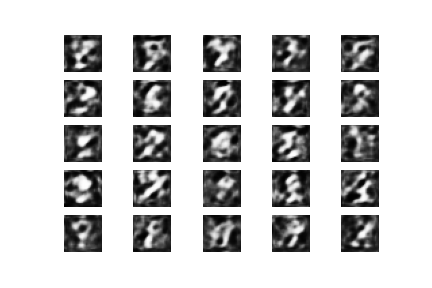

In [67]:
Image(filename=os.path.join(images_dir, 'mnist_8_100.png'))

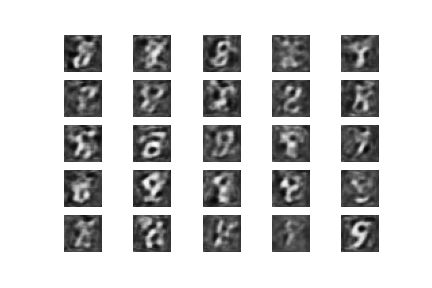

In [68]:
Image(filename=os.path.join(images_dir, 'mnist_8_200.png'))

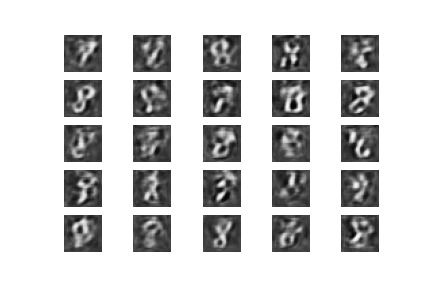

In [69]:
Image(filename=os.path.join(images_dir, 'mnist_8_300.png'))

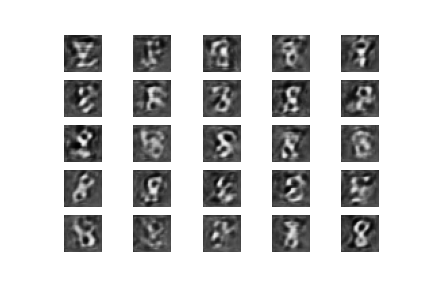

In [70]:
Image(filename=os.path.join(images_dir, 'mnist_8_400.png'))

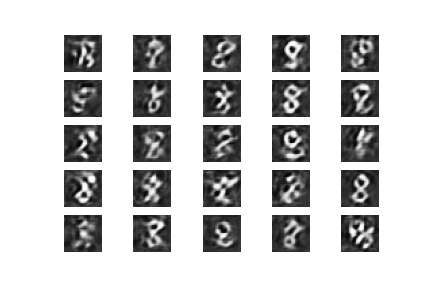

In [71]:
Image(filename=os.path.join(images_dir, 'mnist_8_500.png'))

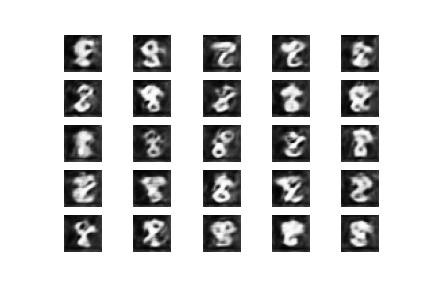

In [72]:
Image(filename=os.path.join(images_dir, 'mnist_8_600.png'))

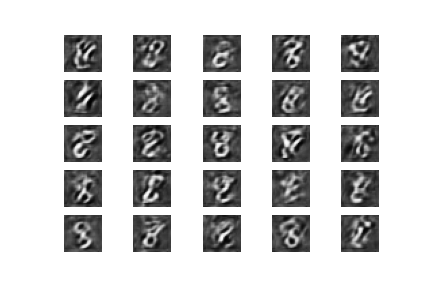

In [73]:
Image(filename=os.path.join(images_dir, 'mnist_8_700.png'))

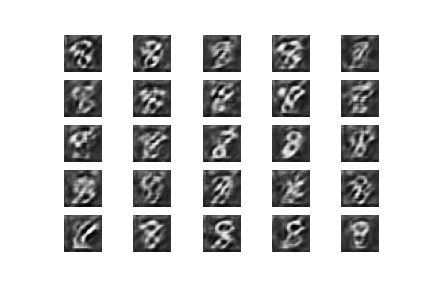

In [74]:
Image(filename=os.path.join(images_dir, 'mnist_8_800.png'))

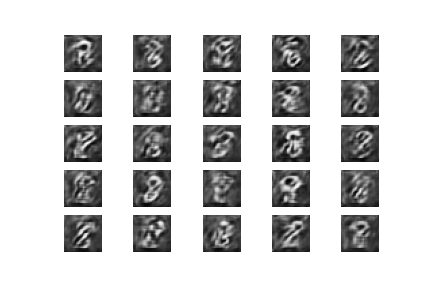

In [75]:
Image(filename=os.path.join(images_dir, 'mnist_8_900.png'))

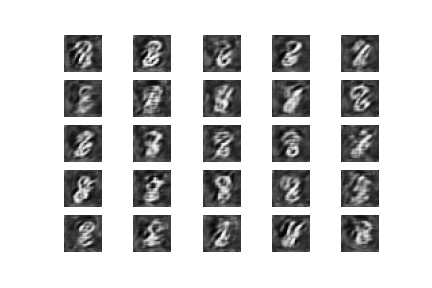

In [76]:
Image(filename=os.path.join(images_dir, 'mnist_8_1000.png'))

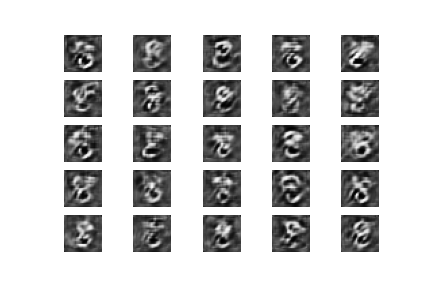

In [77]:
Image(filename=os.path.join(images_dir, 'mnist_8_1100.png'))

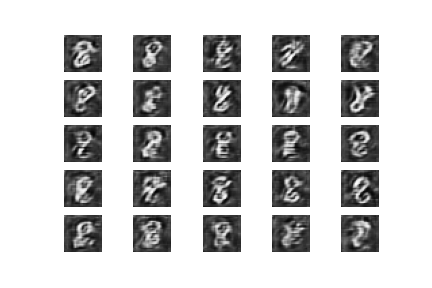

In [78]:
Image(filename=os.path.join(images_dir, 'mnist_8_1200.png'))

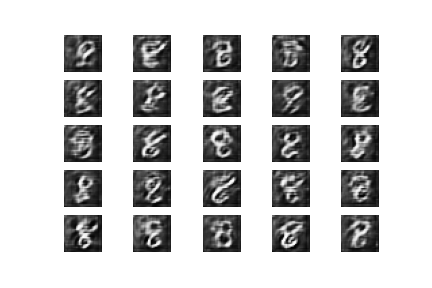

In [79]:
Image(filename=os.path.join(images_dir, 'mnist_8_1300.png'))

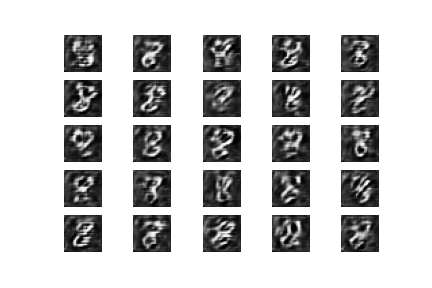

In [80]:
Image(filename=os.path.join(images_dir, 'mnist_8_1400.png'))

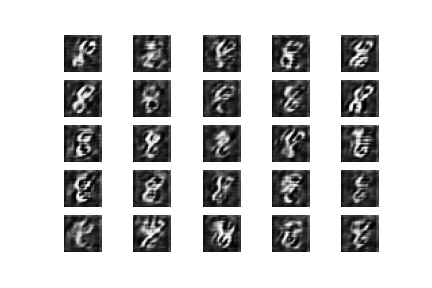

In [81]:
Image(filename=os.path.join(images_dir, 'mnist_8_1500.png'))

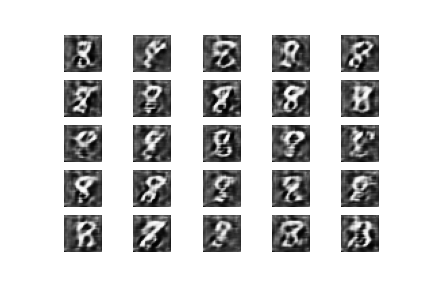

In [82]:
Image(filename=os.path.join(images_dir, 'mnist_8_1600.png'))

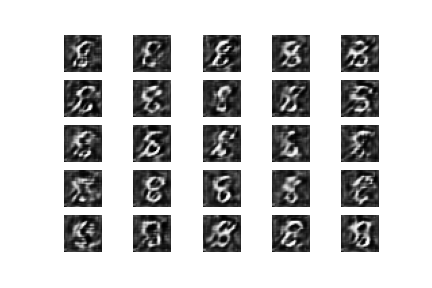

In [83]:
Image(filename=os.path.join(images_dir, 'mnist_8_1700.png'))

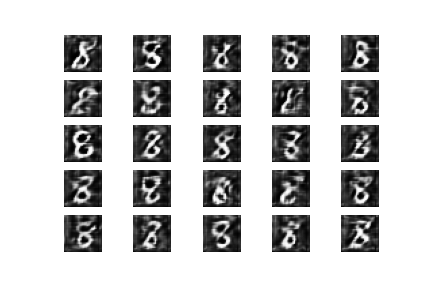

In [85]:
Image(filename=os.path.join(images_dir, 'mnist_8_1800.png'))

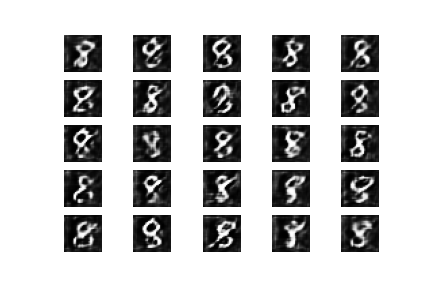

In [86]:
Image(filename=os.path.join(images_dir, 'mnist_8_1900.png'))

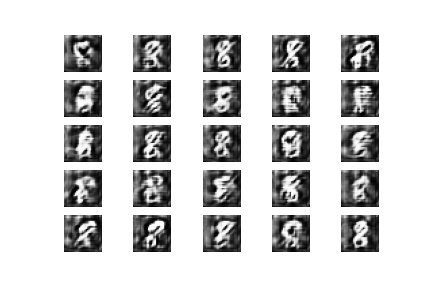

In [87]:
Image(filename=os.path.join(images_dir, 'mnist_8_2000.png'))

Overall this training went very well. The 1900th epoch looks best, and oddly the model declined in the epochs afterwards. I'm not sure how overfitting works on GANs but I assume the generator must have just reverted to looking worse after the discriminator was able to catch the new 8s.

In [123]:
with device('/device:GPU:0'):
    trainon8(generatoron8, discriminatoron8, combinedon8, iterations=101, batch_size=32, save_interval=50)

0 [D loss: 0.035117413848638535, acc.: 100.00%] [G loss: 0.9955242872238159]
50 [D loss: 0.049991076812148094, acc.: 100.00%] [G loss: 0.8574627041816711]
100 [D loss: 0.17017778009176254, acc.: 100.00%] [G loss: 0.6487423181533813]


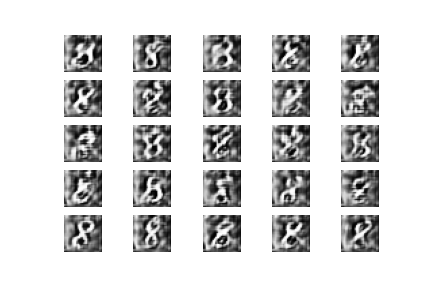

In [125]:
Image(filename=os.path.join(images_dir, 'mnist_8_100.png'))

Even more overfitting.

Next, I trained the same model but on only 5s. My hypothesis was that as a simpler shape, it would require less training to reach the optimal weights.

# Training the model on 5

In [88]:
def trainon5(generator, discriminator, combined, iterations, batch_size=128, save_interval=50):
    '''
    Trains all model objects
    
    generator: the generator model object returned by build_combined
    discriminator: the discriminator model object returned by build_combined
    combined: the combined model object returned by build_combined
    iterations: integer, the number of iterations to train for
    batch_size: integer, the number of training samples to use at a time
    save_interval: integer, will generate and save images when the current iteration_num % save_interval is 0
    
    returns: None
    '''

    # Load the dataset
    (X_train, y_train), (_, _) = mnist.load_data()
    fake_mask = np.array([y_train == 5])
    new_data = []
    for idx in range(0, len(X_train), 1):
        if fake_mask[0][idx]:
            new_data.append(X_train[idx].tolist())
    X_train = np.array(new_data)
    del y_train

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for iteration in range(iterations):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, noise_len))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real images classified as ones and generated images as zeros)
        real = 1
        fake = 0
        # Use noisy labels: about 10% of the time, swap the labels
        # (see https://github.com/soumith/ganhacks)
        if np.random.randint(0, 10) < 1:
            real = 0
            fake = 1
        d_loss_real = discriminator.train_on_batch(imgs, np.zeros((half_batch, 1)) + real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)) + fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, noise_len))

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # If at save interval => save generated image samples and plot progress
        if iteration % save_interval == 0:
            # Plot the progress
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print ("{} [D loss: {}, acc.: {:.2%}] [G loss: {}]".format(iteration, d_loss[0], d_loss[1], g_loss))
            save_imgson5(generator, iteration)

def save_imgson5(generator, iteration):
    '''
    Has the generator create images and saves the images in a single file that includes
    the number of iterations in the filename.
    
    inputs:
        generator: the generator model object returned by build_combined
        iteration: the iteration number (but can be anything that can be represented as a string)
    
    returns: None
    '''
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_len))
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray', vmin=-1, vmax=1)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_5_{}.png'.format(iteration)))
    plt.close()

In [89]:
generatoron5, discriminatoron5, combinedon5 = build_combined()

In [90]:
# Train using GPU acceleration
# (see https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ)
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

# Lower the number of iterations when you start debugging! You want a short testing cycle until you are confident
# that the code is working. Also, since the exercises involve models with less complicated patterns, you will
# likely not need as many iterations to train well.
with device('/device:GPU:0'):
    trainon5(generatoron5, discriminatoron5, combinedon5, iterations=1501, batch_size=32, save_interval=50)

0 [D loss: 1.1378782987594604, acc.: 34.38%] [G loss: 0.6376136541366577]
50 [D loss: 0.6632362902164459, acc.: 59.38%] [G loss: 1.3876473903656006]
100 [D loss: 0.7373156249523163, acc.: 62.50%] [G loss: 1.5448758602142334]
150 [D loss: 0.35712533444166183, acc.: 84.38%] [G loss: 1.3792017698287964]
200 [D loss: 0.42961443960666656, acc.: 81.25%] [G loss: 1.6983561515808105]
250 [D loss: 2.4729589223861694, acc.: 12.50%] [G loss: 1.2354774475097656]
300 [D loss: 0.2633870914578438, acc.: 96.88%] [G loss: 0.9331029653549194]
350 [D loss: 0.22573985159397125, acc.: 93.75%] [G loss: 0.7097650766372681]
400 [D loss: 2.4344241619110107, acc.: 0.00%] [G loss: 0.31006360054016113]
450 [D loss: 0.1857857182621956, acc.: 96.88%] [G loss: 0.48801252245903015]
500 [D loss: 0.36011940240859985, acc.: 90.62%] [G loss: 0.38143157958984375]
550 [D loss: 1.2003307342529297, acc.: 31.25%] [G loss: 0.1384984403848648]
600 [D loss: 0.10550492256879807, acc.: 100.00%] [G loss: 0.7412312626838684]
650 [D 

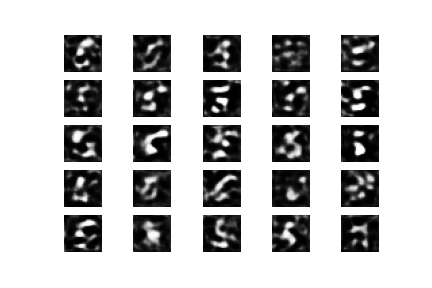

In [91]:
Image(filename=os.path.join(images_dir, 'mnist_5_100.png'))

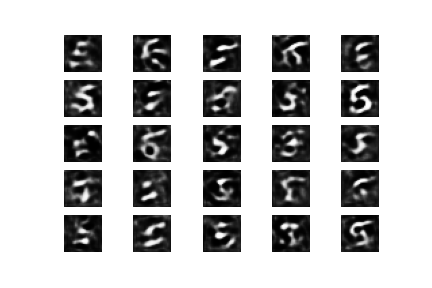

In [92]:
Image(filename=os.path.join(images_dir, 'mnist_5_200.png'))

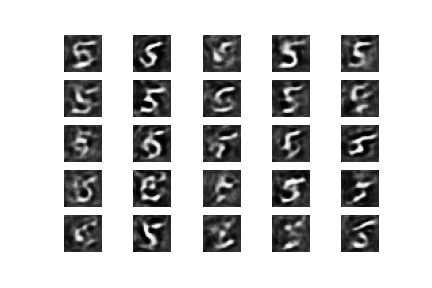

In [93]:
Image(filename=os.path.join(images_dir, 'mnist_5_300.png'))

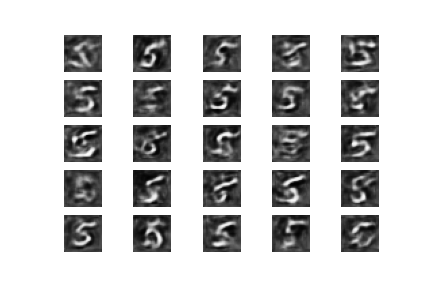

In [94]:
Image(filename=os.path.join(images_dir, 'mnist_5_400.png'))

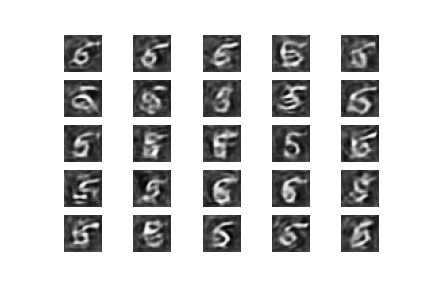

In [95]:
Image(filename=os.path.join(images_dir, 'mnist_5_500.png'))

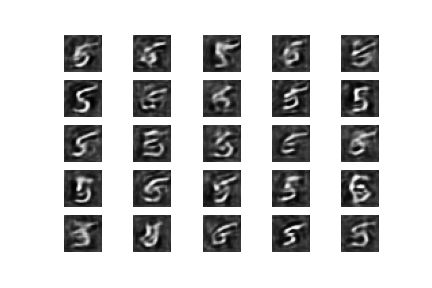

In [96]:
Image(filename=os.path.join(images_dir, 'mnist_5_600.png'))

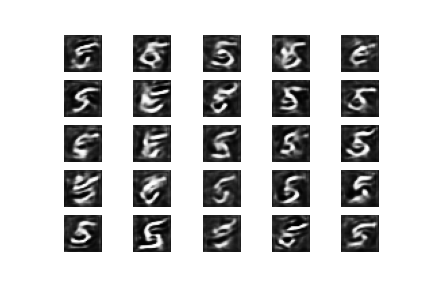

In [97]:
Image(filename=os.path.join(images_dir, 'mnist_5_700.png'))

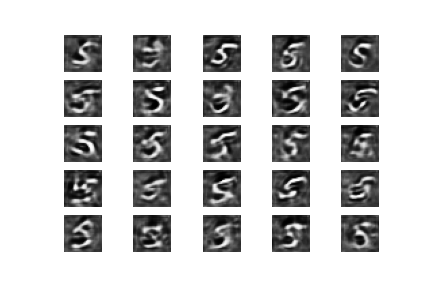

In [98]:
Image(filename=os.path.join(images_dir, 'mnist_5_800.png'))

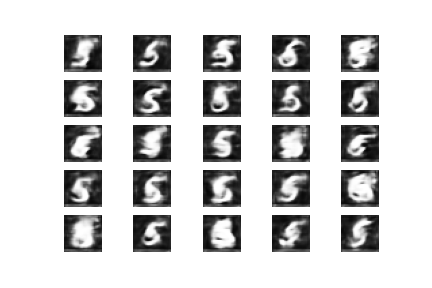

In [99]:
Image(filename=os.path.join(images_dir, 'mnist_5_900.png'))

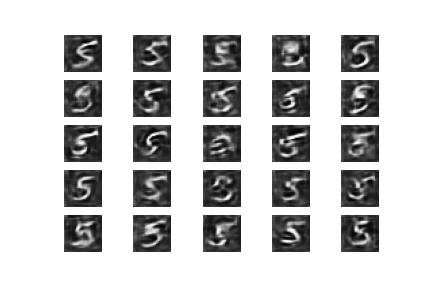

In [100]:
Image(filename=os.path.join(images_dir, 'mnist_5_1000.png'))

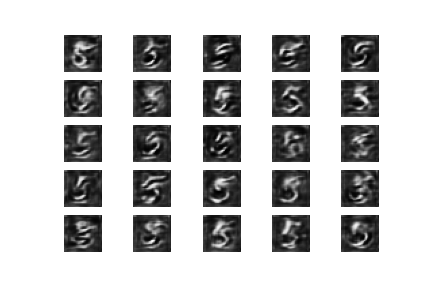

In [101]:
Image(filename=os.path.join(images_dir, 'mnist_5_1100.png'))

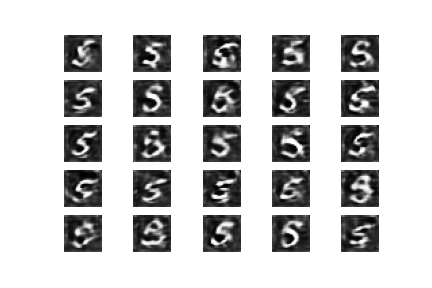

In [102]:
Image(filename=os.path.join(images_dir, 'mnist_5_1200.png'))

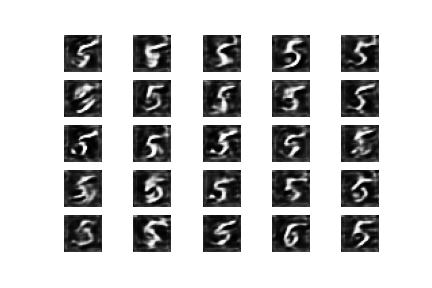

In [103]:
Image(filename=os.path.join(images_dir, 'mnist_5_1300.png'))

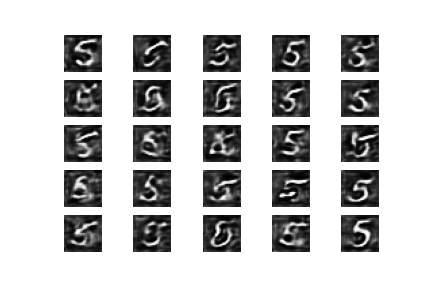

In [104]:
Image(filename=os.path.join(images_dir, 'mnist_5_1400.png'))

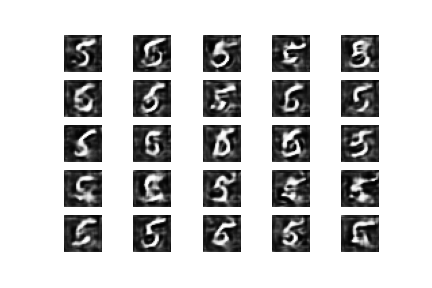

In [105]:
Image(filename=os.path.join(images_dir, 'mnist_5_1500.png'))

In [118]:
with device('/device:GPU:0'):
    trainon5(generatoron5, discriminatoron5, combinedon5, iterations=100, batch_size=32, save_interval=50)

0 [D loss: 0.16378464177250862, acc.: 96.88%] [G loss: 1.0652503967285156]


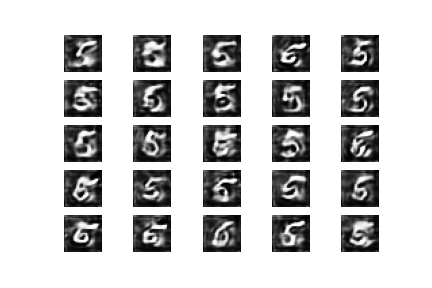

In [107]:
Image(filename=os.path.join(images_dir, 'mnist_5_100.png'))

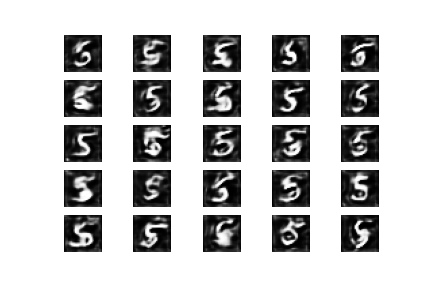

In [108]:
Image(filename=os.path.join(images_dir, 'mnist_5_200.png'))

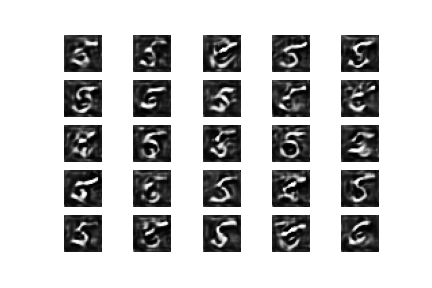

In [109]:
Image(filename=os.path.join(images_dir, 'mnist_5_300.png'))

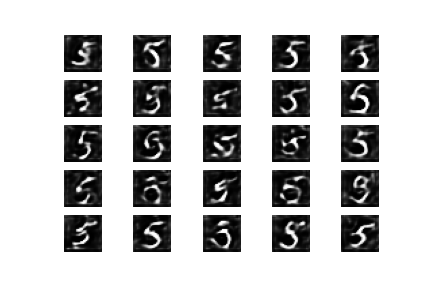

In [110]:
Image(filename=os.path.join(images_dir, 'mnist_5_400.png'))

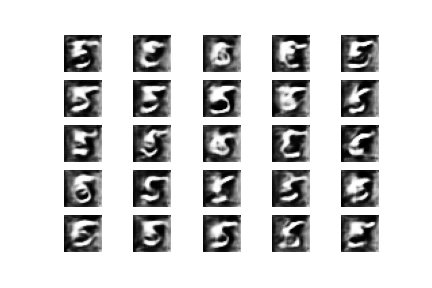

In [111]:
Image(filename=os.path.join(images_dir, 'mnist_5_500.png'))

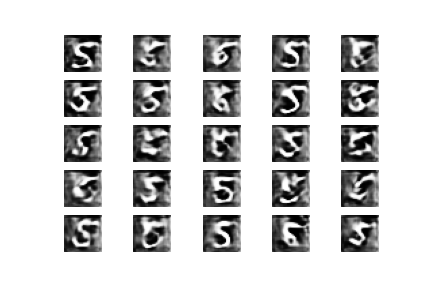

In [116]:
Image(filename=os.path.join(images_dir, 'mnist_5_100.png'))

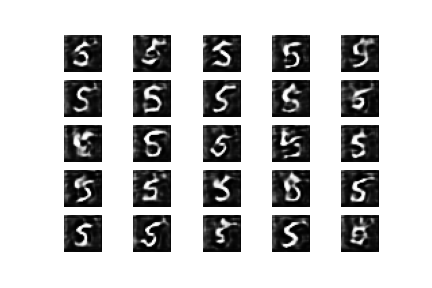

In [119]:
Image(filename=os.path.join(images_dir, 'mnist_5_0.png'))  # 2200th generation??

Interestingly, here I found that the 2200th epoch looked best, although very early on in the trianing there were quite accurate looking generated numbers, such as epoch 1300.

In [127]:
generatoron5.save('Gen5Model')
discriminatoron5.save('Dis5Model')
combinedon5.save('Com5Model')

INFO:tensorflow:Assets written to: Gen5Model/assets
INFO:tensorflow:Assets written to: Dis5Model/assets
INFO:tensorflow:Assets written to: Com5Model/assets


In [128]:
!zip -r /content/Gen5Model.zip /content/Gen5Model
!zip -r /content/Dis5Model.zip /content/Dis5Model
!zip -r /content/Com5Model.zip /content/Com5Model

  adding: content/Gen5Model/ (stored 0%)
  adding: content/Gen5Model/assets/ (stored 0%)
  adding: content/Gen5Model/saved_model.pb (deflated 89%)
  adding: content/Gen5Model/variables/ (stored 0%)
  adding: content/Gen5Model/variables/variables.index (deflated 58%)
  adding: content/Gen5Model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Dis5Model/ (stored 0%)
  adding: content/Dis5Model/assets/ (stored 0%)
  adding: content/Dis5Model/saved_model.pb (deflated 90%)
  adding: content/Dis5Model/variables/ (stored 0%)
  adding: content/Dis5Model/variables/variables.index (deflated 71%)
  adding: content/Dis5Model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/Com5Model/ (stored 0%)
  adding: content/Com5Model/assets/ (stored 0%)
  adding: content/Com5Model/saved_model.pb (deflated 90%)
  adding: content/Com5Model/variables/ (stored 0%)
  adding: content/Com5Model/variables/variables.index (deflated 73%)
  adding: content/Com5Model/variabl

In [129]:
!zip -r /content/dcgan_images.zip /content/dcgan_images

  adding: content/dcgan_images/ (stored 0%)
  adding: content/dcgan_images/mnist_8_1250.png (deflated 6%)
  adding: content/dcgan_images/mnist_8_1900.png (deflated 6%)
  adding: content/dcgan_images/mnist_400.png (deflated 6%)
  adding: content/dcgan_images/mnist_1550.png (deflated 6%)
  adding: content/dcgan_images/mnist_8_0.png (deflated 6%)
  adding: content/dcgan_images/mnist_350.png (deflated 6%)
  adding: content/dcgan_images/mnist_8_350.png (deflated 5%)
  adding: content/dcgan_images/mnist_500.png (deflated 5%)
  adding: content/dcgan_images/mnist_8_1800.png (deflated 6%)
  adding: content/dcgan_images/mnist_8_1750.png (deflated 6%)
  adding: content/dcgan_images/mnist_1450.png (deflated 6%)
  adding: content/dcgan_images/mnist_8_1550.png (deflated 6%)
  adding: content/dcgan_images/mnist_8_1950.png (deflated 6%)
  adding: content/dcgan_images/mnist_1500.png (deflated 6%)
  adding: content/dcgan_images/mnist_5_550.png (deflated 4%)
  adding: content/dcgan_images/mnist_5_1500.pn

In [130]:
from google.colab import files
files.download("/content/Gen5Model.zip")
files.download("/content/Dis5Model.zip")
files.download("/content/Com5Model.zip")
files.download("/content/dcgan_images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Actual attempt at exercise 2
This was where I tried to do what exercise 2 was actually asking, where you input a number into the model and it outputs a generated image of that number. For this I would have to change the model a lot. After some discussion, I decided that I would do this by appending two bits which would signify whether the model should output a 0 or a 2, these two number being chosen because they are relatively simple shapes but different enough to clearly be recognized. I left my comments on the changes in the code below:

In [76]:
def build_discriminator():
    '''
    Put together a CNN that will return a single confidence output.
    
    returns: the model object
    '''

    # There wasn't much to change in the actual discriminator model
    img_shape = (img_rows, img_cols, channels)

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    # The biggest change was in this last line, in which the model outputs 3 units, one for 0 how
    # confident it is that the image is a 0, one for 2, and one for "fake" meaning it thinks it was generated

    return model

def build_generator():
    '''
    Put together a model that takes in one-dimensional noise and outputs two-dimensional
    data representing a black and white image, with -1 for black and 1 for white.
    
    returns: the model object
    '''

    # The generator also had few changes
    noise_shape = (noise_len+2,)
    # The additional 2 here is for onehot encoding the inputted number

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D(interpolation="bilinear"))
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D(interpolation="bilinear"))
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

def build_combined():
    '''
    Puts together a model that combines the discriminator and generator models.
    
    returns: the generator, discriminator, and combined model objects
    '''
    
    optimizer = Adam(0.0002, 0.5)

    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])


    generator = build_generator()

    noise = Input(shape=(noise_len+2,))
    img = generator(noise)
    
    discriminator.trainable = False

    valid = discriminator(img)  # 3 element list btw

    combined = Model(inputs=noise, outputs=valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator, discriminator, combined

def save_imgs(generator, iteration):
    '''
    Has the generator create images and saves the images in a single file that includes
    the number of iterations in the filename.
    
    inputs:
        generator: the generator model object returned by build_combined
        iteration: the iteration number (but can be anything that can be represented as a string)
    
    returns: None
    '''
    r, c = 5, 5
    # This part below had to be changed so that instead of just generating random images, it would
    # generate half 0s and half 2s
    noise = np.random.normal(0, 1, (r * c, noise_len+2))
    noise[:13, 100] = 1  # [1,0] in the last two slots means a 0
    noise[13:, 100] = 0
    noise[:13, 101] = 0 # [0,1] in the last two slots means a 2
    noise[13:, 101] = 1
    # It's doing up to and from the 13th one because there are 25 slots
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray', vmin=-1, vmax=1)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_{}.png'.format(iteration)))
    plt.close()

def train(generator, discriminator, combined, iterations, batch_size=128, save_interval=50):
    '''
    Trains all model objects
    
    generator: the generator model object returned by build_combined
    discriminator: the discriminator model object returned by build_combined
    combined: the combined model object returned by build_combined
    iterations: integer, the number of iterations to train for
    batch_size: integer, the number of training samples to use at a time
    save_interval: integer, will generate and save images when the current iteration_num % save_interval is 0
    
    returns: None
    '''

    # Load the dataset
    # This also changed a lot because now I had to load both the 0s and the 2s
    (X_train, y_train), (_, _) = mnist.load_data()
    zero_mask = np.array([y_train == 0])  # making a separate mask on the mnist set for each
    two_mask = np.array([y_train == 2])
    
    new0_data = []  # loading the 0s
    for idx in range(len(X_train)):
        if zero_mask[0][idx]:
            new0_data.append(X_train[idx].tolist())
    X0_train = np.array(new0_data)
    
    new2_data = []  # loading the 2s
    for idx in range(len(X_train)):
        if two_mask[0][idx]:
            new2_data.append(X_train[idx].tolist())
    X2_train = np.array(new2_data)

    # Rescale -1 to 1
    X0_train = (X0_train.astype(np.float32) - 127.5) / 127.5
    X0_train = np.expand_dims(X0_train, axis=3)
    X2_train = (X2_train.astype(np.float32) - 127.5) / 127.5
    X2_train = np.expand_dims(X2_train, axis=3)

    half_batch = int(batch_size / 2)

    for iteration in range(iterations):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X0_train.shape[0], half_batch)
        imgs0 = X0_train[idx]
        idx = np.random.randint(0, X2_train.shape[0], half_batch)
        imgs2 = X2_train[idx]

        # Sample noise and generate a half batch of new images
        # Again, here we have to generate two separate batches of images
        noise = np.random.normal(0, 1, (half_batch, noise_len+2))
        noise[:, 100] = 1
        noise[:, 101] = 0
        gen_imgs0 = generator.predict(noise)

        noise = np.random.normal(0, 1, (half_batch, noise_len+2))
        noise[:, 100] = 0
        noise[:, 101] = 1
        gen_imgs2 = generator.predict(noise)

        # Train the discriminator (real images classified as ones and generated images as zeros)
        # In the following few lines, I generate separate lists for the results of classifying all
        # the images as fully 0, fully 2, or fully fake
        real0 = np.zeros((half_batch, 3))
        real0[:, 0] = 1
        real2 = np.zeros((half_batch, 3))
        real2[:, 1] = 1
        fake = np.zeros((half_batch, 3))
        fake[:, 2] = 1
        # Use noisy labels: about 10% of the time, swap the labels
        # (see https://github.com/soumith/ganhacks)
        if np.random.randint(0, 10) < 1:
            real0 = np.zeros((half_batch, 3))
            real0[:, np.random.randint(1,3)] = 1
            real2 = np.zeros((half_batch, 3))
            real2[:, np.random.randint(2)*2] = 1
            fake = np.zeros((half_batch, 3))
            fake[:, np.random.randint(2)] = 1
        
        # This is where I train the discriminator
        d_loss_real0 = discriminator.train_on_batch(imgs0, real0)
        # In the above line I am training the discriminator to recognize real 0s as real 0s
        # I wonder if having separate fake categories would work better?
        d_loss_fake0 = discriminator.train_on_batch(gen_imgs0, fake)
        # Here it's training it to recognize
        # generated 0s as fake
        d_loss_real2 = discriminator.train_on_batch(imgs2, real2)
        d_loss_fake2 = discriminator.train_on_batch(gen_imgs2, fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        noise = np.random.normal(0, 1, (batch_size, noise_len+2))
        noise[:, 100] = 1
        noise[:, 101] = 0
        g_loss0 = combined.train_on_batch(noise, np.concatenate((real0, real0)))
        # I had to concatenate here because it was on a full batch and not a half batch

        noise = np.random.normal(0, 1, (batch_size, noise_len+2))
        noise[:, 100] = 0
        noise[:, 101] = 1
        g_loss2 = combined.train_on_batch(noise, np.concatenate((real2, real2)))

        # If at save interval => save generated image samples and plot progress
        if iteration % save_interval == 0:
            # Plot the progress
            # I had to change the average calculations here to include both numbers
            # We can't do binary accuracy anymore because it's not two options, it's three
            d_loss = np.concatenate((d_loss_real0, d_loss_fake0, d_loss_real2, d_loss_fake2))
            d_loss = 0.25 * d_loss.sum(axis=0)
            g_loss = 0.5 * np.add(g_loss0, g_loss2)
            #print(d_loss, g_loss)
            print ("{} [D loss: {}] [G loss: {}]".format(iteration, d_loss, g_loss))
            save_imgs(generator, iteration)
            
def show_new_image(generator, number):
    '''
    Generates and displays a new image
    
    inputs: generator object model returned from build_combined
    
    returns: generated image
    '''
    
    # This part appends the number to the generator input
    noise = np.random.normal(0, 1, (1, noise_len+2))
    noise[0, 100] = int(not number)
    noise[0, 101] = int(number)
    gen_img = generator.predict(noise)[0][:,:,0]
    
    return plt.imshow(gen_img, cmap='gray', vmin=-1, vmax=1)

In [10]:
f = np.random.normal(0, 1, (1, noise_len+2))
h = 1
f[0, 100] = int(not h)
f[0, 101] = int(h)
f

array([[-0.23383119,  1.21690922,  1.0503328 , -0.41794665, -0.24945997,
         0.70658633,  0.23794259,  0.55508796,  1.30876634,  0.55321482,
        -0.18855277, -1.52735808,  0.51788861, -0.0389807 ,  0.30153036,
        -1.56507339,  0.23684347,  0.63510944, -0.2876257 ,  2.4630528 ,
         1.36805179,  0.2697447 ,  0.49229742, -0.70139136,  0.46923774,
         0.27622114, -0.01005422,  2.30786556,  0.50616808,  1.97652217,
        -0.15902886, -0.88829554, -0.8310798 , -0.91550474, -0.88154581,
        -0.26754817, -1.18886919,  0.21465898, -1.49766701,  0.95024201,
         0.08705103,  0.3646371 ,  0.12481586,  1.3510429 ,  0.85745103,
         0.12881116,  1.8948379 ,  0.87507826, -0.95717447, -1.33752043,
         0.23083192, -0.19143509, -0.70555612, -1.08075096,  1.72364065,
        -0.8326456 ,  1.17726102,  0.59674953, -2.15515054, -1.52935496,
        -0.14219908, -0.14338487,  1.09156319, -0.43616138,  2.10950549,
         0.84219509, -1.81143743, -1.09873353, -1.8

In [77]:
generator, discriminator, combined = build_combined()

In [13]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              646016    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)      

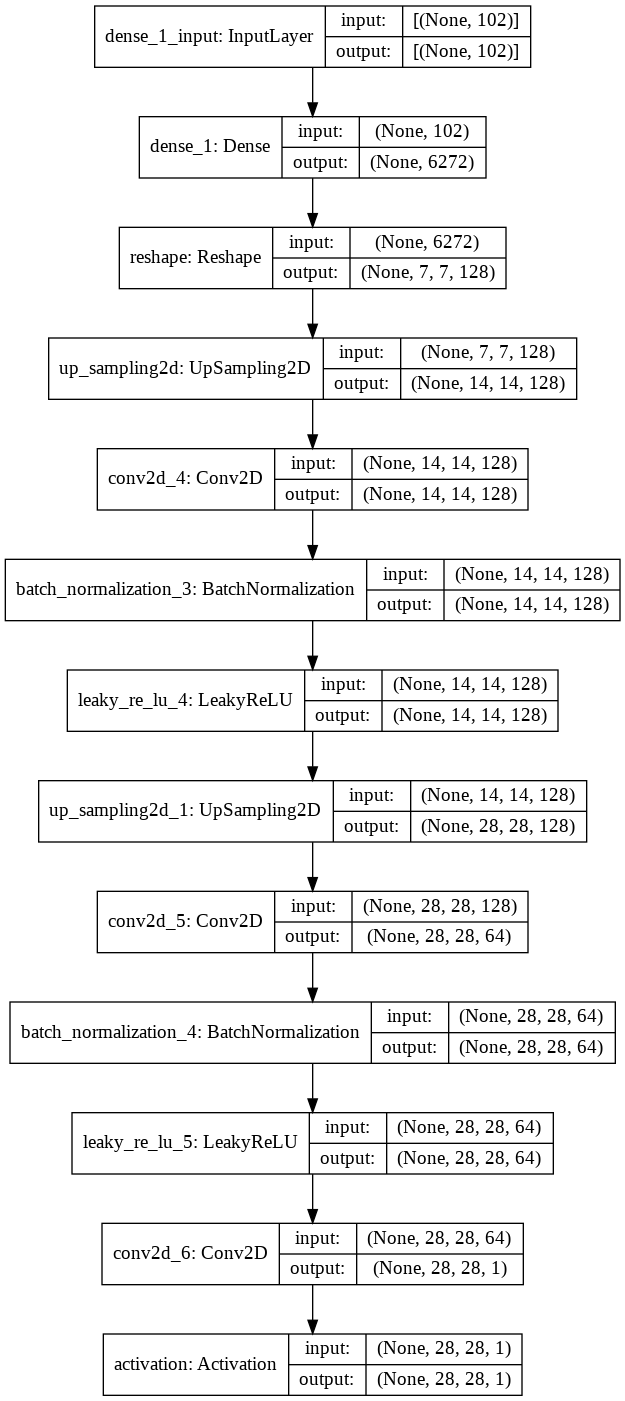

In [14]:
from keras.utils import plot_model
plot_model(generator, show_shapes=True)

In [15]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

In [16]:
combined.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         868737    
_________________________________________________________________
sequential (Sequential)      (None, 3)                 401923    
Total params: 1,270,660
Trainable params: 868,353
Non-trainable params: 402,307
_________________________________________________________________


# Round 1 of training

In [78]:
# Train using GPU acceleration
# (see https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ)
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

# Lower the number of iterations when you start debugging! You want a short testing cycle until you are confident
# that the code is working. Also, since the exercises involve models with less complicated patterns, you will
# likely not need as many iterations to train well.
with device('/device:GPU:0'):
    train(generator, discriminator, combined, iterations=1001, batch_size=32, save_interval=50)

0 [D loss: 1.1797916740179062] [G loss: 0.6958275139331818]
50 [D loss: 1.107120655477047] [G loss: 0.7801677882671356]
100 [D loss: 1.0841599851846695] [G loss: 0.831754058599472]
150 [D loss: 1.1516708210110664] [G loss: 0.6295108497142792]
200 [D loss: 1.2104881294071674] [G loss: 0.792030543088913]
250 [D loss: 1.136583372950554] [G loss: 0.7903831601142883]
300 [D loss: 1.1775070689618587] [G loss: 0.6819673776626587]
350 [D loss: 1.0716068078763783] [G loss: 0.7063597142696381]
400 [D loss: 1.092775346711278] [G loss: 0.7304109930992126]
450 [D loss: 1.0865912083536386] [G loss: 0.4343908429145813]
500 [D loss: 1.1789808962494135] [G loss: 0.6968018114566803]
550 [D loss: 1.0934897186234593] [G loss: 0.4815324693918228]
600 [D loss: 1.1371219102293253] [G loss: 0.5107955932617188]
650 [D loss: 1.0930101410485804] [G loss: 0.6721088886260986]
700 [D loss: 1.1088650857564062] [G loss: 0.8668192028999329]
750 [D loss: 1.0511936550028622] [G loss: 0.662731409072876]
800 [D loss: 1.10

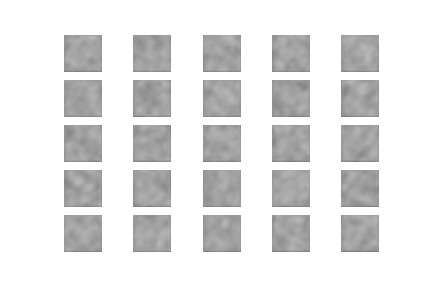

In [79]:
Image(filename=os.path.join(images_dir, 'mnist_0.png'))

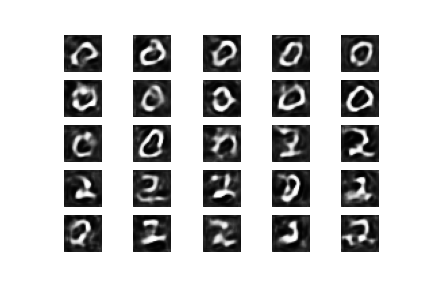

In [80]:
Image(filename=os.path.join(images_dir, 'mnist_200.png'))

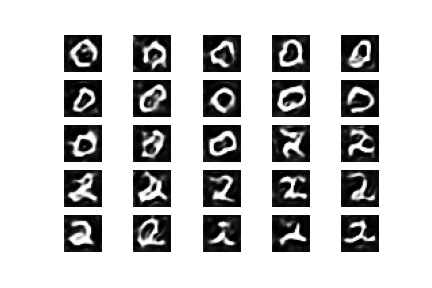

In [86]:
Image(filename=os.path.join(images_dir, 'mnist_300.png'))

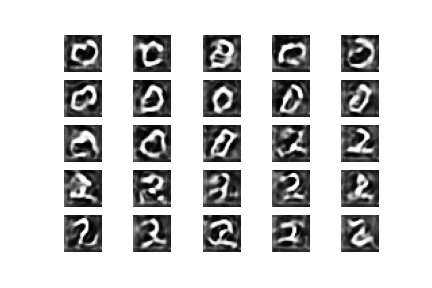

In [96]:
Image(filename=os.path.join(images_dir, 'mnist_350.png'))

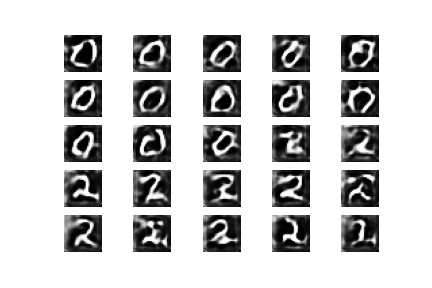

In [81]:
Image(filename=os.path.join(images_dir, 'mnist_400.png'))

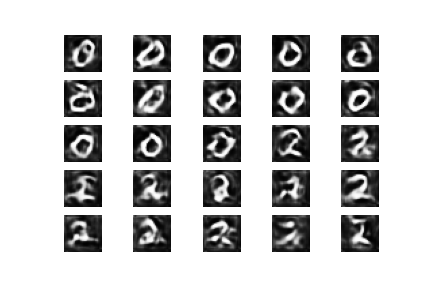

In [95]:
Image(filename=os.path.join(images_dir, 'mnist_450.png'))

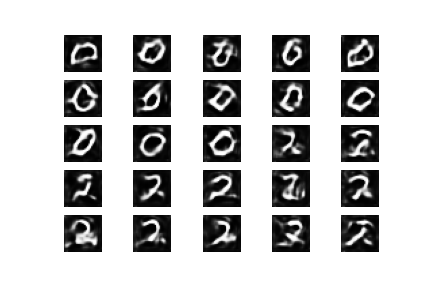

In [87]:
Image(filename=os.path.join(images_dir, 'mnist_500.png'))

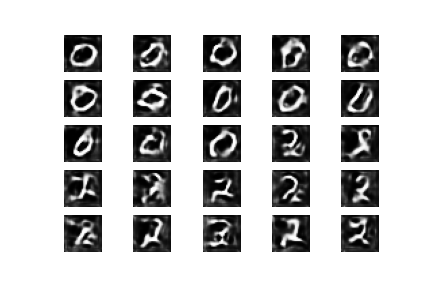

In [94]:
Image(filename=os.path.join(images_dir, 'mnist_550.png'))

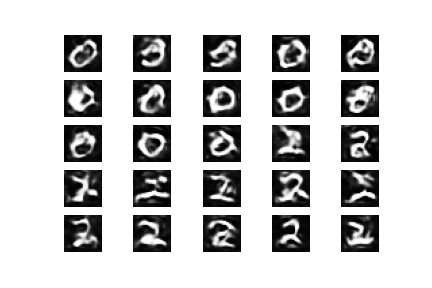

In [82]:
Image(filename=os.path.join(images_dir, 'mnist_600.png'))

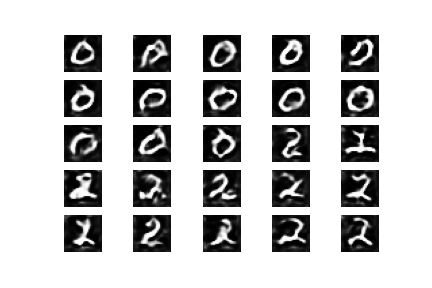

In [93]:
Image(filename=os.path.join(images_dir, 'mnist_650.png'))

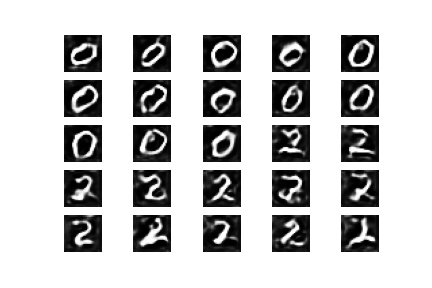

In [88]:
Image(filename=os.path.join(images_dir, 'mnist_700.png'))

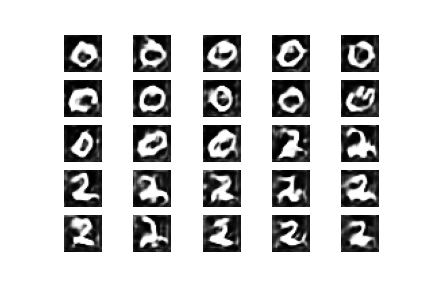

In [92]:
Image(filename=os.path.join(images_dir, 'mnist_750.png'))

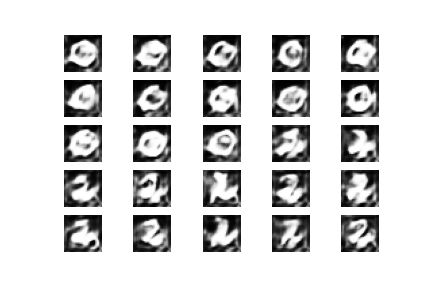

In [84]:
Image(filename=os.path.join(images_dir, 'mnist_800.png'))

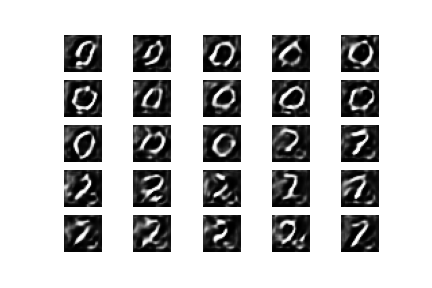

In [91]:
Image(filename=os.path.join(images_dir, 'mnist_850.png'))

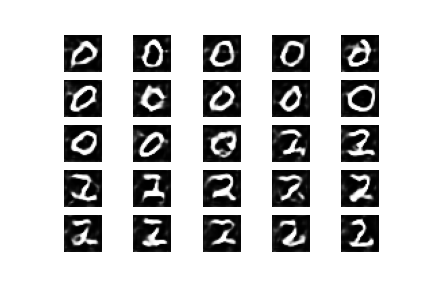

In [89]:
Image(filename=os.path.join(images_dir, 'mnist_900.png'))

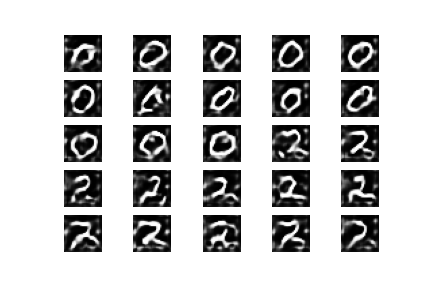

In [90]:
Image(filename=os.path.join(images_dir, 'mnist_950.png'))

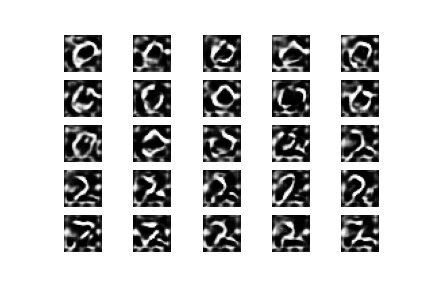

In [85]:
Image(filename=os.path.join(images_dir, 'mnist_1000.png'))

The first round of training went pretty well, much better than training on the whole dataset. The 0s came out looking really good in almost all the images, but the 2s had more trouble. I think they looked best in the 900th epoch.

# Round 2 of training
Here I trained the same model for another 1000 epochs

In [97]:
with device('/device:GPU:0'):
    train(generator, discriminator, combined, iterations=1001, batch_size=32, save_interval=50)

0 [D loss: 1.12101698666811] [G loss: 0.689680814743042]
50 [D loss: 1.1516249254345894] [G loss: 0.5546312630176544]
100 [D loss: 1.1017056051641703] [G loss: 0.49681416153907776]
150 [D loss: 1.0938637116923928] [G loss: 0.49854668974876404]
200 [D loss: 1.1533246003091335] [G loss: 0.44673529267311096]
250 [D loss: 1.1697008777409792] [G loss: 0.6621839106082916]
300 [D loss: 1.0263813852798194] [G loss: 0.8199147582054138]
350 [D loss: 1.0529572162777185] [G loss: 0.7471167147159576]
400 [D loss: 1.0740478336811066] [G loss: 0.3744533061981201]
450 [D loss: 1.0787128051742911] [G loss: 0.5969466865062714]
500 [D loss: 2.0682568550109863] [G loss: 0.9300271272659302]
550 [D loss: 1.0950378999114037] [G loss: 0.46698305010795593]
600 [D loss: 1.0562882465310395] [G loss: 0.7631609439849854]
650 [D loss: 1.0675132204778492] [G loss: 0.527686595916748]
700 [D loss: 1.0598394558764994] [G loss: 0.4977610260248184]
750 [D loss: 1.1590396836400032] [G loss: 0.8221030533313751]
800 [D loss

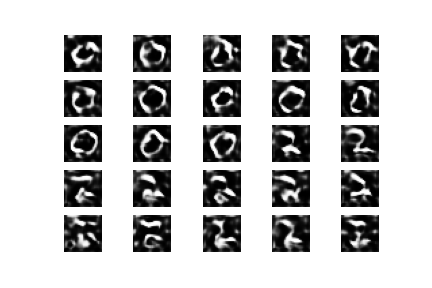

In [111]:
Image(filename=os.path.join(images_dir, 'mnist_50.png'))

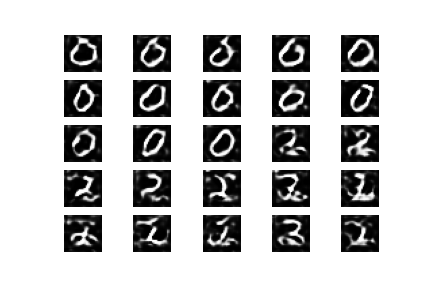

In [98]:
Image(filename=os.path.join(images_dir, 'mnist_100.png'))

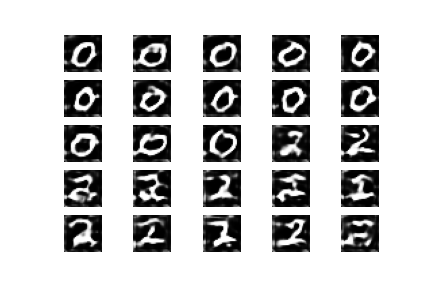

In [110]:
Image(filename=os.path.join(images_dir, 'mnist_150.png'))

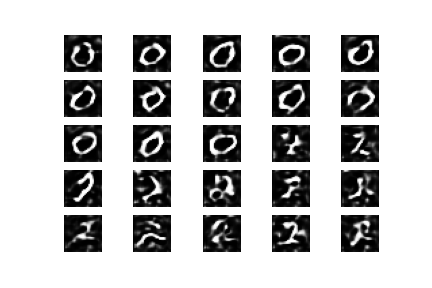

In [ ]:
Image(filename=os.path.join(images_dir, 'mnist_200.png'))

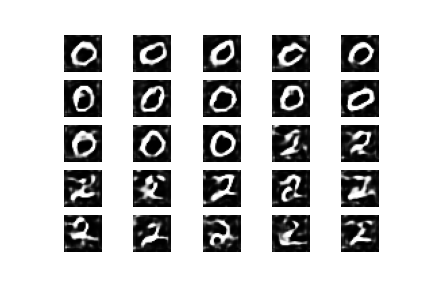

In [109]:
Image(filename=os.path.join(images_dir, 'mnist_250.png'))

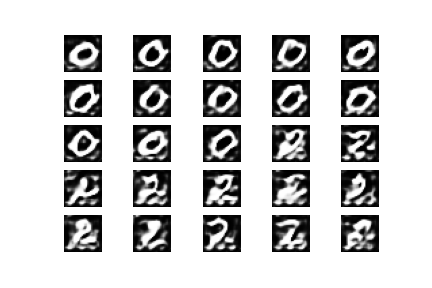

In [100]:
Image(filename=os.path.join(images_dir, 'mnist_300.png'))

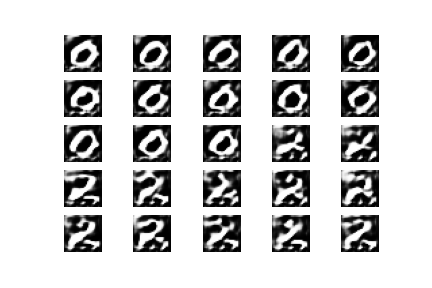

In [101]:
Image(filename=os.path.join(images_dir, 'mnist_400.png'))

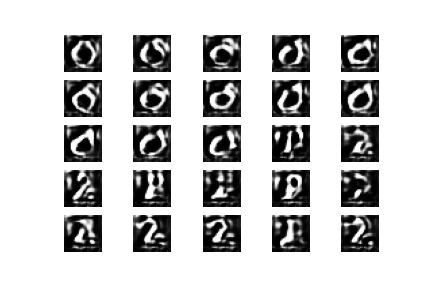

In [102]:
Image(filename=os.path.join(images_dir, 'mnist_500.png'))

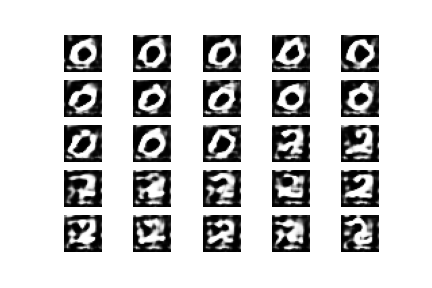

In [103]:
Image(filename=os.path.join(images_dir, 'mnist_600.png'))

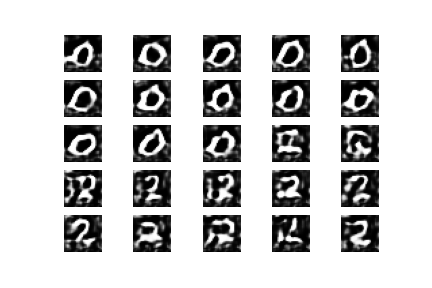

In [114]:
Image(filename=os.path.join(images_dir, 'mnist_650.png'))

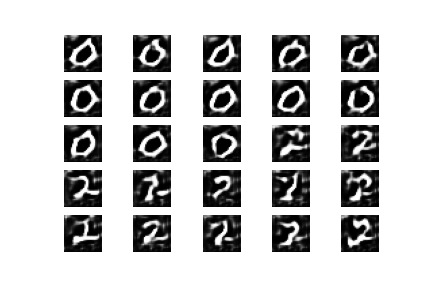

In [104]:
Image(filename=os.path.join(images_dir, 'mnist_700.png'))

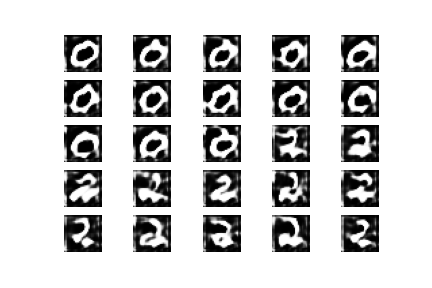

In [112]:
Image(filename=os.path.join(images_dir, 'mnist_750.png'))

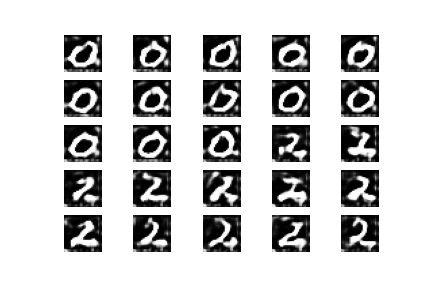

In [105]:
Image(filename=os.path.join(images_dir, 'mnist_800.png'))

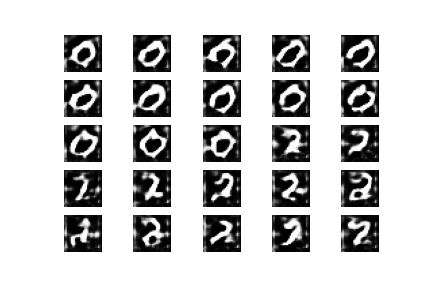

In [108]:
Image(filename=os.path.join(images_dir, 'mnist_850.png'))

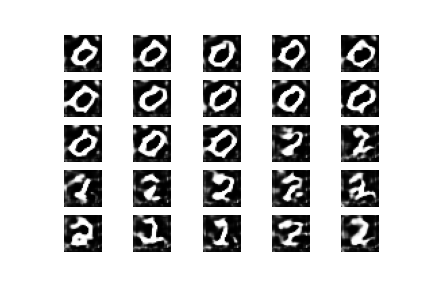

In [106]:
Image(filename=os.path.join(images_dir, 'mnist_900.png'))

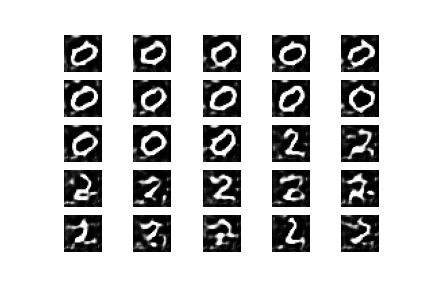

In [113]:
Image(filename=os.path.join(images_dir, 'mnist_950.png'))

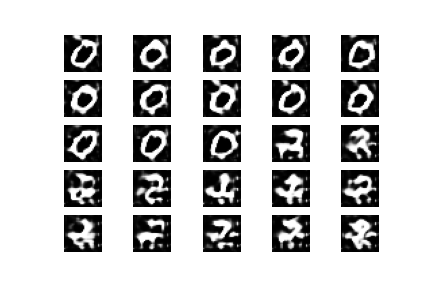

In [107]:
Image(filename=os.path.join(images_dir, 'mnist_1000.png'))

This additional training did not help much, but at least the model did not degrade much like other GANs I worked with for this assignment. I still think the original epoch 900 looks the best, but epoch 800 in the second round might rival it. Overall I would rate this exercise a strong success.

Next I worked on the mugshots, which you can see in the MugshotsProcessing and MugshotsGAN notebooks.

# Exercise Option #3 - Advanced Difficulty
You may notice the current GAN with 2000 iterations only gives so-so output. Unfortunately, if you keep training past this point, the output just gets worse. I haven't yet been able to figure out how to change the model to get better results. Can you?